<a href="https://colab.research.google.com/github/yuji-sgs/m1-reserch/blob/main/Inverse_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに
## 本ノートブックの目的
フォノニック結晶（音を遮断する物質）の材料・構造（C2, s）と遮音(BandGap)の関係を深層学習モデルで学習し、所望の遮音データを設定した際に材料・構造データを逆問題的に解析していく

## 処理フロー
1. 使用するライブラリをインポート
2. データの読み込み・確認
3. データ分割
4. KerasのSequentialモデルで学習
5. 学習後の精度評価
6. 逆解析

## 1. 使用するライブラリをインポート

In [ ]:
# 使用するライブラリをインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import io
from google.colab import files

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

## 2. データの読み込み・確認
ローカルにあるファイルからGoogle Colaboratoryにアップロード

In [ ]:
# Google Colaboratoryでファイルをアップロード
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
# データフレームとして、変数dfに3列×10000行のデータを格納（C2：材料パラメータ, s：構造パラメータ, BandGap1：遮音パラメータ）
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))
df

,C2,s,BandGap1
0,0.15,0.01,6.689500e+00
1,0.30,0.01,5.649800e+00
2,0.45,0.01,4.264400e+00
3,0.60,0.01,2.945800e+00
4,0.75,0.01,1.748300e+00
...,...,...,...
9995,14.40,1.00,4.090000e-12
9996,14.55,1.00,7.840000e-12
9997,14.70,1.00,2.270000e-13
9998,14.85,1.00,4.550000e-12


## 3. データ分割
学習用データとテスト用データに分割

In [ ]:
# データの分割
(train, test) = train_test_split(df, test_size=0.2, shuffle=True)

In [ ]:
# x_train, x_testではcsvファイルの1列目から2列目を，y_train, y_testでは3列目のデータを活用
x_train = train.iloc[:, [0, 1]]
y_train = train.iloc[:, [2]]

x_test = test.iloc[:, [0, 1]]
y_test = test.iloc[:, [2]]

## 4. KerasのSequentialモデルで学習
### モデルの概要
- 入力層：2ノード(C2, s)
- 中間層：3層, 各層32ノード
- 出力層：1ノード（BandGap1）

### 活性化関数
- ReLUを採用（勾配消失問題の解消, 処理速度が速い, 多くの場合高い性能を示す）

### 損失関数
- 回帰問題に適したMSE（平均二乗誤差）を採用

### 最適化アルゴリズム
- Adamを採用（Kingma氏らが2014年に提案した高い性能を示すことで知られている | 参考：[Adam: A Method for Stochastic Optimization](https://www.semanticscholar.org/paper/Adam%3A-A-Method-for-Stochastic-Optimization-Kingma-Ba/a6cb366736791bcccc5c8639de5a8f9636bf87e8)）
  - ハイパーパラメータは提案論文の推奨値で決定
    - lr：学習率
    - beta_1：過去の勾配の指数移動平均を計算する際の減衰係数
    - beta_2：過去の勾配の二乗の指数移動平均を計算する際の減衰係数

### その他ハイパーパラメータ
- 学習回数：150回
- バッチサイズ：64

In [ ]:
# モデルの構築
# inputの数（C2, s）
n_in = 2

# ノードの数
n_hidden = 32

# outputの数(BandGap1)
n_out = 1

# 学習回数
epochs = 150
batch_size = 64

model = Sequential()
model.add(Dense(n_hidden, activation= 'relu', input_dim=n_in))
model.add(Dense(n_hidden, activation= 'relu', input_dim=n_in))
model.add(Dense(n_hidden, activation= 'relu', input_dim=n_in))
model.add(Dense(units=n_out))
model.summary()

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 学習オプション
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/150
125/125 [==============================] - 2s 5ms/step - loss: 187034.9688 - val_loss: 94111.3281
Epoch 2/150
125/125 [==============================] - 1s 5ms/step - loss: 78925.7500 - val_loss: 78465.1094
Epoch 3/150
125/125 [==============================] - 1s 6ms/step - loss: 76001.7969 - val_loss: 76550.8594
Epoch 4/150
125/125 [==============================] - 1s 7ms/step - loss: 74275.6172 - val_loss: 75315.8828
Epoch 5/150
125/125 [==============================] - 1s 6ms/step - loss: 72749.8281 - val_loss: 73136.8125
Epoch 6/150
125/125 [==============================] - 1s 6ms/step - loss: 70998.4609 - val_loss: 71004.9375
Epoch 7/150
125/125 [==============================] - 1s 4ms/step - loss: 68954.1484 - val_loss: 68530.6797
Epoch 8/150
125/125 [==============================] - 1s 6ms/step - loss: 66121.6953 - val_loss: 65460.0430
Epoch 9/150
125/125 [==============================] - 1s 9ms/step - loss: 62879.4219 - val_loss: 61270.7070
Epoch 10/150
125/1

In [ ]:
# 構築したモデルで予測
test_predict = model.predict(x_test)

63/63 [==============================] - 0s 2ms/step


## 5. 学習後の精度評価

## 精度評価指標
### MAE（Mean Absolute Error | 平均絶対誤差）
- 各データに対して「予測値と正解値の差(=誤差)」の絶対値を計算し、その総和をデータ数で割った値(=平均値)を出力する関数。0に近いほど良い。

### RMSE（Root Mean Squared Error | 二乗平均平方根誤差）
- 各データに対して「予測値と正解値の差(=誤差)」の二乗値を計算し, その総和をデータ数で割った値(=平均値)の平方根をとって出力する関数。0に近いほど良い。

### 決定係数（Coefficient of Determination | R^2）
- 出力の実測値と出力の予測値の間の相関係数を表す。1に近づくをほど良い。

参考：https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/

In [ ]:
#精度評価指標
# MAE
test_MAE = mean_absolute_error(y_test, test_predict)
print('MAE：', test_MAE)

# MSE
test_MSE = mean_squared_error(y_test, test_predict)
print('MSE：', test_MSE)

# RMSE
test_RMSE = sqrt(mean_squared_error(y_test, test_predict))
print('RMSE：', test_RMSE)

# 決定係数
R2 = r2_score(y_test, test_predict)
print('R2：', R2)

MAE： 8.804411709031575
MSE： 171.27672662852535
RMSE： 13.08727346044719
R2： 0.9983051104218779


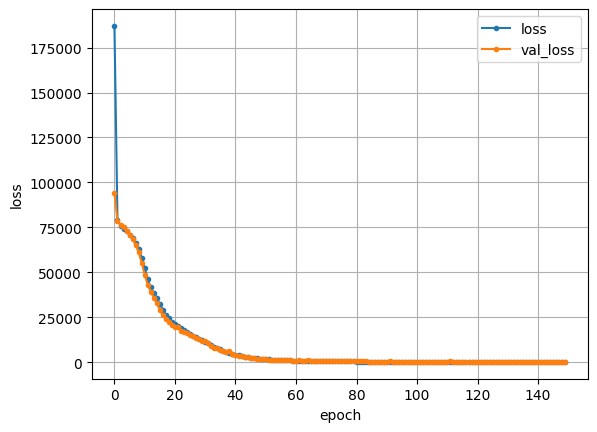

In [ ]:
# 損失関数のプロット
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

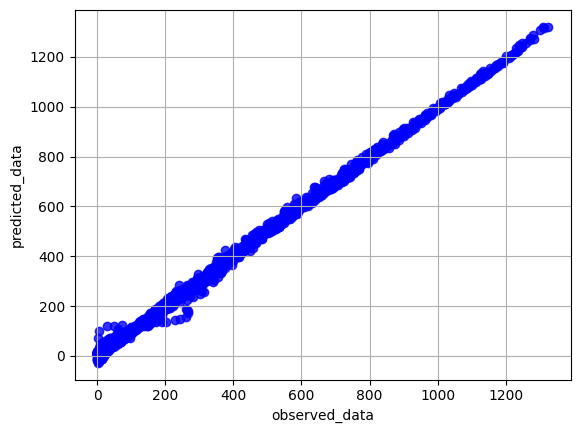

In [ ]:
# Observed-Predicted（横軸に実測値、縦軸に予測値をプロットしたグラフ）
plt.figure()
plt.scatter(y_test, test_predict, c='blue', alpha=0.8)
plt.ylim(plt.ylim())
plt.grid()
plt.xlabel('observed_data')
plt.ylabel('predicted_data')
plt.show()

## 6. 逆解析

### 逆解析のアルゴリズム
1. 出力（BandGap）の所望値を設定する
2. 入力パラメータ（C2, s）をランダムに設定する
3. 学習済みモデルに②で設定したパラメータを入力する | f(C2, s)
4. ③−①の2乗を損失関数として定義 | Loss = (f(C2, s) – y)^2
5. ④で設定した損失関数の勾配計算を行う | ∇(f(C2, s) – y)^2
6. 勾配計算で得たベクトルと学習率（α）を掛け合わせて、入力パラメータを更新
7. 損失関数が小さくなるような入力パラメータ（C2_new, s_new）が得られるまで繰り返し計算

In [ ]:
import tensorflow as tf

# パラメータの初期値を設定
target_bandgap = tf.constant([1000.0], dtype=tf.float32)

# 初期の入力値をランダムに設定（C2は0から15の範囲、sは0から1の範囲に制限）
c2 = tf.Variable(tf.random.uniform([1], 0, 15))
s = tf.Variable(tf.random.uniform([1], 0, 1))

# 最適化手法を定義
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# 各値を保存するリスト
c2_values = []
s_values = []
predicted_bandgap_values = []

# 損失関数の値を保存するリスト
loss_values = []

# 更新回数
step = 1000

# パラメータ更新を実行
for step in range(step):
    # 勾配計算を行うためのAPI
    with tf.GradientTape() as tape:

        # モデルの出力を定義(予測値を計算)
        predicted_bandgap = model(tf.stack([c2, s], axis=1))
        # 損失関数を定義（予測値と目標値の平均二乗誤差を計算）
        loss = tf.reduce_mean(tf.square(predicted_bandgap - target_bandgap))

    # 勾配を計算(損失に対する各パラメータC2とsの勾配（偏微分）を計算)
    gradients = tape.gradient(loss, [c2, s])
    # 最適化手法を適用(計算された勾配を使用してパラメータC2とsを更新)
    optimizer.apply_gradients(zip(gradients, [c2, s]))

    # 各値を保存
    c2_values.append(c2.numpy()[0])
    s_values.append(s.numpy()[0])
    predicted_bandgap_values.append(predicted_bandgap.numpy()[0])

    # 損失関数の値を保存
    loss_values.append(loss.numpy())

    # 10ステップごとに結果を出力
    if step % 10 == 0:
        print(f'Epoch: {step}, Loss: {loss.numpy()}, C2: {c2.numpy()}, s: {s.numpy()}')

# 最終的な学習結果を出力(C2とsのパラメータ)
print(f'Loss: {loss.numpy()}, C2: {c2.numpy()}, s: {s.numpy()}')

Epoch: 0, Loss: 494535.5, C2: [6.9451103], s: [0.6103868]
Epoch: 10, Loss: 325694.3125, C2: [7.042476], s: [0.50970167]
Epoch: 20, Loss: 194432.828125, C2: [7.143204], s: [0.41320643]
Epoch: 30, Loss: 113539.875, C2: [7.2608366], s: [0.3314275]
Epoch: 40, Loss: 59387.375, C2: [7.3727074], s: [0.26077878]
Epoch: 50, Loss: 57777.94140625, C2: [7.4795723], s: [0.22403353]
Epoch: 60, Loss: 48947.59375, C2: [7.5933766], s: [0.23691575]
Epoch: 70, Loss: 42548.53125, C2: [7.6992164], s: [0.25486857]
Epoch: 80, Loss: 38435.28515625, C2: [7.7905474], s: [0.24285711]
Epoch: 90, Loss: 34843.44921875, C2: [7.8830104], s: [0.24843448]
Epoch: 100, Loss: 31731.8203125, C2: [7.970878], s: [0.24837765]
Epoch: 110, Loss: 29377.73828125, C2: [8.05519], s: [0.24429305]
Epoch: 120, Loss: 26966.134765625, C2: [8.138248], s: [0.24388842]
Epoch: 130, Loss: 24929.353515625, C2: [8.219063], s: [0.24283026]
Epoch: 140, Loss: 23092.478515625, C2: [8.297882], s: [0.24156947]
Epoch: 150, Loss: 20885.224609375, C2: 

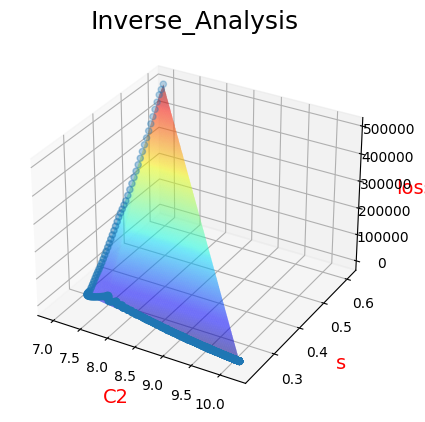

In [ ]:
# 入力パラメータが更新されていった際の損失関数をグラフで可視化
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# x,y,zに要素追加
x = np.array(c2_values)
y = np.array(s_values)
z = np.array(loss_values)

# scipy.interpolate.griddata() でサンプリングしなおす
x_new, y_new = np.meshgrid(np.linspace(x.min(), x.max(), len(x)), np.linspace(y.min(), y.max(), len(y)))
z_new = griddata((x, y), z, (x_new, y_new), method='linear')

# Figureを追加
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Axesのタイトルを設定
ax.set_title("Inverse_Analysis", size = 18)
# 軸ラベルを設定
ax.set_xlabel("C2", size = 14, color = "r")
ax.set_ylabel("s", size = 14, color = "r")
ax.set_zlabel("loss", size = 14, color = "r")
ax.plot_surface(x_new, y_new, z_new, rstride=1, cstride=10, cmap='jet', alpha=0.7)
ax.scatter(c2_values, s_values, loss_values)
plt.show()

# 今後の展望
- より有意義な逆解析にしていきたいため、複数出力に対する逆解析を実現していきたい。
- そのために複数出力の深層学習モデルを構築し、逆解析で複数の損失関数を定義して、それぞれの損失関数が小さくなるように入力パラメータの更新を行なっていけば良い。
- しかし、多くの場合それぞれの損失関数の最小値が一つの入力パラメータに定まらず、トレードオフな関係になってしまう
- この問題を解決していくために、多目的最適化アルゴリズムを構築する必要がある。
- 今後は「[だれでも分かる多目的最適化問題超入門](https://qiita.com/sp4ghet/items/f3dfbfe24b0a9c4997ee)」の記事を参考に、多目的最適化アルゴリズムを構築して、複数出力に対する逆解析を実装していくつもりだ。
